
## Purpose and Results

Classification of Reuters news articles by topic.  Useful for Reuters' analytics in providing niche customers (e.g., those in the cocoa industry, see below) with targeted articles about their space.  The same idea is useful in Reuters' legal operations, as follows: for a customer engaged in a legal dispute relating to one of its products (e.g. from the FTC, or e.g. Apple v. Samsung), helpful to sort through e-mails and other internal documents relevant to that product in a red-team analysis.

Load in and decompress a .tar.gz file from the UCI archive containing Reuters news articles.  Twenty-one uncompressed .smd files contain nearly twelve thousand news articles in somewhat dirty form.  Extract the article bodies (inputs) and topics (outputs), ignoring those articles lacking a topic or having multiple topics.

Exploratory data analysis reveals substantial class imbalance, with 'earn' and 'acq' classes accounting for more than 2/3 of total articles.  In addition to class imbalance, it is also the case that the available classes are not exhaustive, given the huge variety of news topics.

Simple baseline model consisting of word frequency tokenization of article bodies followed by fitting of a small dense neural network.  Accuracy of ~85% on validation set, with analysis of errors revealing a weakness in predicting the minority classes.

Next, transfer learning model using a DistilBert tokenization and pre-trained model.  Accuracy of ~91% on validation set.  Attempt to incorporate a custom loss function, the FocalLoss, to improve performance on minority classes.

Computational requirements for the second model are substantially greater, requiring a GPU or TPU, but there are fewer design choices and less tuning needed.

TO DO: Save transfer learning model following fine-tuning.  Write a separate program that allows the user to specify a Reuters or Bloomberg financial news article as input, returning the probable topic of the input article as predicted by the model.

## Packages and Colab GPU Connection



In [1]:
!pip install wget
!pip install wordcloud
!pip install transformers

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e612afe4c797bea80a34fad0bbe9f5ca3560246768199e5fef43413ca1cb4900
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 573kB 6.4MB/s 
     |████████████████████████████████| 3.7MB 29.2MB/s 
     |████████████████████████████████| 890kB 39.4MB/s 
     |████████████████████████████████| 1.0MB 36.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=8522318220bbfb9fb37a7ff32d939ffd8144845b38840d14dc727e98c923f027
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [2]:
import string
import os
import wget
import numpy as np
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from keras.preprocessing.text import Tokenizer

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import regularizers

import transformers

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel, AutoTokenizer

The transfer learning model has steep computation requirements and is not easily trained by a CPU.  The following code connects us to a Colab GPU unit, offering a substantial performance increase.

In [6]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Text Extraction and Exploratory Data Analysis

In [0]:
# data obtained from UCI repo
# unpack .tar.gz file

In [0]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/reuters21578.tar.gz'

In [0]:
if not os.path.exists('./reuters21578.tar.gz'):
    wget.download(url, './reuters21578.tar.gz')

In [0]:
if not os.path.exists('./reuters21578'):
  !tar -xf reuters21578.tar.gz

In [0]:
folder = './'

In [0]:
#os.listdir(folder)
#around twenty .sgm files, each containing multiple articles

In [0]:
example = open(os.path.join(folder, 'reut2-009.sgm'), encoding = 'utf8', errors = 'ignore').read()

In [0]:
# need to extract the article's topics and text
# note that many articles lack a topic
#print(example)

In [0]:
# containers for article topics and bodies

article_topics = []
article_bodies = []

# topic counts dictionary to store topic frequency

topic_counts = {}

In [0]:
# load the data from disparate .sgm files into topic, bodies, and topic_counts containers

# text tag ending each of the article bodies
reuters = 'Reuter\n&#3;'


for fname in sorted(os.listdir(folder)):
    if 'sgm' in fname:
        data = open(os.path.join(folder, fname), encoding = 'utf8', errors = 'ignore').read()
        topic_begin = '<TOPICS>'
        topic_end = '</TOPICS>'
        body_tag = '<BODY>'
        
        while topic_begin in data:
            data = data[data.find(topic_begin) + len(topic_begin):]
            topic = data[:data.find(topic_end)]
            if topic and '</D><D>' not in topic: # non-empty, single label
                topic = topic.replace('<D>', '').replace('</D>','')
                article_topics.append(topic)
                topic_counts[topic] = topic_counts.get(topic, 0) + 1
            else:
                continue # ignore non-empty or multi-label articles
                
            body = data[data.find(body_tag) + len(body_tag):]
            body = body[: body.find('</') - len(reuters)] # further remove 'Reuter\n&#3;'
            body.replace('\n', '')
            article_bodies.append(body)

In [17]:
print(len(topic_counts), len(article_bodies))

66 9494


In [0]:
#print(article_bodies[0])

In [19]:
article_topics[0]

'cocoa'

In [0]:
#topic_counts

In [0]:
# retain only those topics that appear more than COUNT_THRESHOLD times

# our learning algorithm will only be able to provide predictions on a given class
# with suitable training data available for the same

COUNT_THRESHOLD = 30 # must have >= this many samples of a given topic to retain this topic

In [0]:
retained_topics = []
retained_bodies = []

retained_counts = {}

In [0]:
for x in topic_counts.keys():
    if topic_counts[x] >= COUNT_THRESHOLD:
        retained_counts[x] = topic_counts[x]

In [0]:
for i in range(len(article_topics)):
    if retained_counts.get(article_topics[i], 0) != 0:
        retained_topics.append(article_topics[i])
        retained_bodies.append(article_bodies[i])

In [25]:
print(len(retained_counts), len(retained_bodies))

26 9114


In [0]:
NUMBER_CATEGORIES = len(retained_counts)

In [27]:
NUMBER_CATEGORIES

26

In [0]:
# plot the class distributions

# huge class imbalance, with 'acq' and 'earn' classes constituting the vast majority
# of news articles

Plot the class distributions.

Huge class imbalance, with 'acq' and 'earn' classes constituting the vast majority of news articles.

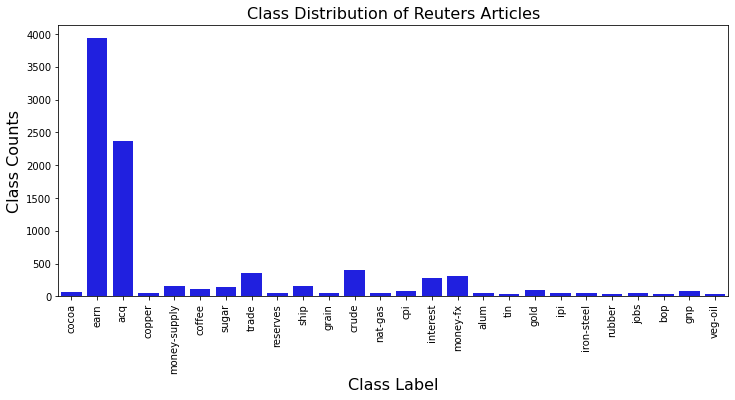

In [29]:
plt.figure(figsize=(12,5))
sns.countplot(x = retained_topics, color = 'blue')
plt.title('Class Distribution of Reuters Articles', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [0]:
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None, # uses wordcloud's default stopwords
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [0]:
# combine all the text from 'acq' and 'earn' articles, then pass the same to wordcloud

acq_text = ''
for i in range(len(retained_topics)):
    if retained_topics[i] == 'acq':
        acq_text += retained_bodies[i]
        
earn_text = ''
for i in range(len(retained_topics)):
    if retained_topics[i] == 'earn':
        earn_text += retained_bodies[i]
    

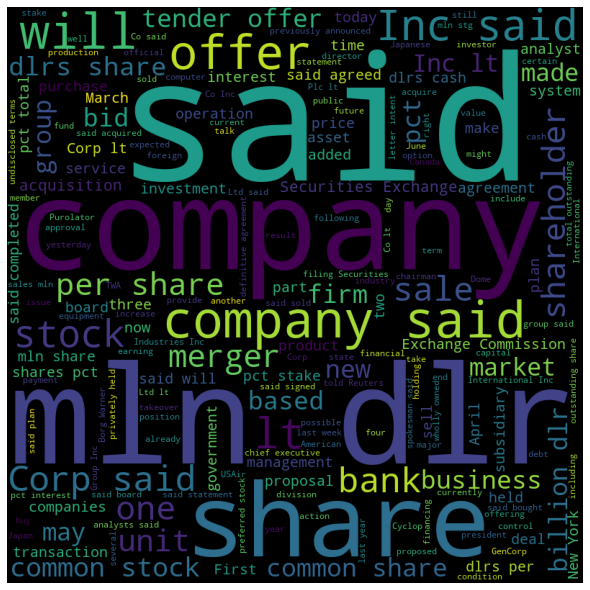

In [32]:
plot_word_cloud(acq_text)

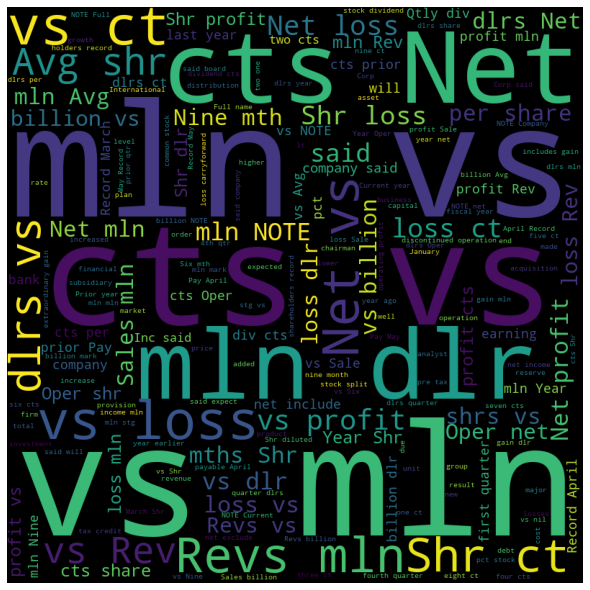

In [33]:
plot_word_cloud(earn_text)

## One-Hot Encoded Output Labels

Now we tokenize and vectorize our output labels.  First, we map the output labels to integer values.  Then, outputs are transformed using the to_categorical utility function, mapping an integral class label k to a vector of length NUMBER_CATEGORIES with the k-th entry set to one and the remaining entries set to zero.

In [0]:
temp = list(retained_counts.keys())

In [0]:
labels_to_categories = {}

In [0]:
for i in range(len(temp)):
    labels_to_categories[temp[i]] = i

In [0]:
#labels_to_categories

In [0]:
for i in range(len(retained_topics)):
    retained_topics[i] = labels_to_categories.get(retained_topics[i])

In [0]:
outputs = np.array(retained_topics)

In [40]:
outputs[0:10]

array([0, 1, 2, 1, 1, 1, 1, 3, 1, 1])

In [0]:
outputs = to_categorical(outputs)

In [42]:
outputs[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Dense Neural Network Model w/ Word Frequency Tokenization


We first construct a simple DNN baseline, trainable on a laptop CPU.  We begin by tokenizing our data, replacing words with their frequency relative to the total data set.

In [0]:
WORD_THRESHOLD = 10000 # only retain the 10,000 most common words
EPOCHS = 20
BATCH_SIZE = 256

In [0]:
tokenizer = Tokenizer(num_words = WORD_THRESHOLD) # Keras utility function

In [0]:
tokenizer.fit_on_texts(retained_bodies)

In [0]:
tokenized_bodies = tokenizer.texts_to_sequences(retained_bodies)

In [0]:
tokenized_bodies = np.array(tokenized_bodies)

In [0]:
#tokenized_bodies[0]

Transform inputs via one-hot encoding, mapping a list of integers in the range [1, WORD_THRESHOLD] to a vector of length WORD_THRESHOLD with values 0 or 1 at the k-th entry depending upon the absence or presence of k in our list.  Note that word order is lost.

In [0]:
def one_hot_encoding(sequences, dimension = WORD_THRESHOLD):
    result = np.zeros((len(sequences), dimension))
    for i in range(len(sequences)):
        for j in range(len(sequences[i])):
            if sequences[i][j] < dimension:
                result[i, sequences[i][j]] = 1
    return result

In [0]:
inputs = one_hot_encoding(tokenized_bodies)

In [51]:
inputs[0]

array([0., 1., 1., ..., 0., 0., 0.])

Randomly assign 30% of the dataset as validation data, training on the remainder.

In [0]:
training_inputs, validation_inputs, training_outputs, validation_outputs =\
train_test_split(inputs, outputs, test_size = .3)

In [53]:
print(training_inputs.shape, validation_inputs.shape)

(6379, 10000) (2735, 10000)


Construct a simple dense neural network model.

In [0]:
DNN = models.Sequential()
DNN.add(layers.Dense(64, activation = 'relu', 
                       kernel_regularizer =  regularizers.l2(.001),
                       input_shape = (WORD_THRESHOLD,)))
DNN.add(layers.Dense(64, activation = 'relu', 
                      kernel_regularizer= regularizers.l2(.001)))
DNN.add(layers.Dense(NUMBER_CATEGORIES, activation = 'softmax'))

In [0]:
DNN.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

The network is densely connected, with two intermediate layers each having 64 nodes. In each intermediate layer, we use the rectified linear unit ('relu') activation function.

Observe the softmax activation function in our final network layer, an appropriate choice for a multiclass classification model. In addition, note the use of the categorical cross-entropy loss function and the accuracy performance metric in the .compile() parameter list.  Other performance metric choices include precision and recall.

To combat overfitting, we add regularization terms to the model, which add the norm-squared of layer weight terms to the loss function specified below.  We could instead reduce the network size or add drop-out terms to the network (see e.g. denseNN_binaryclass.ipynb).

In [56]:
outcome = DNN.fit(training_inputs, training_outputs, epochs = EPOCHS, batch_size = BATCH_SIZE,
         validation_data = (validation_inputs, validation_outputs))

Train on 6379 samples, validate on 2735 samples
Epoch 1/20
6379/6379 [==============================] - 10s 2ms/step - loss: 1.9584 - accuracy: 0.6572 - val_loss: 1.2968 - val_accuracy: 0.7378
Epoch 2/20
6379/6379 [==============================] - 1s 79us/step - loss: 1.0505 - accuracy: 0.7913 - val_loss: 1.0492 - val_accuracy: 0.8029
Epoch 3/20
6379/6379 [==============================] - 0s 77us/step - loss: 0.8040 - accuracy: 0.8630 - val_loss: 0.9616 - val_accuracy: 0.8278
Epoch 4/20
6379/6379 [==============================] - 0s 78us/step - loss: 0.6542 - accuracy: 0.8998 - val_loss: 0.8897 - val_accuracy: 0.8548
Epoch 5/20
6379/6379 [==============================] - 0s 77us/step - loss: 0.5487 - accuracy: 0.9263 - val_loss: 0.8540 - val_accuracy: 0.8567
Epoch 6/20
6379/6379 [==============================] - 0s 75us/step - loss: 0.4845 - accuracy: 0.9422 - val_loss: 0.8780 - val_accuracy: 0.8384
Epoch 7/20
6379/6379 [==============================] - 0s 75us/step - loss: 0.436

In [0]:
#outcome.history.keys()

In [0]:
epochs = range(1, EPOCHS + 1)
accuracy = outcome.history.get('accuracy')
val_accuracy = outcome.history.get('val_accuracy')

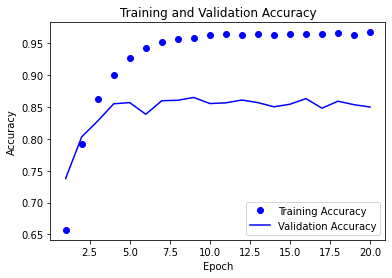

In [59]:
plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plot above shows a monotonic increase in training accuracy and an increase and mild decline in validation accuracy.  This behavior can also be seen in the callbacks generated by the .fit() method above.  The model appears to be overfitting the training data as we iterate over more and more epochs.  One way to combat this overfitting is to partially train the model, halting training at an early epoch (say, the eleventh epoch).  Further steps beyond this early stopping and our earlier use of regularization include adding drop-out terms to the network (see e.g. denseNN_binaryclass.ipynb) or decreasing the network size.  

Recall that the dataset features a high class imbalance, with the majority of samples belonging to the 'acq' and 'earn' classes.  In such situations, it is often the case that the classification model underperforms on minority classes.  Examination of the data below shows this to be true for the DNN model.

First we calculate proportional contribution of the classes to total error.

In [0]:
validation_preds = np.round(DNN.predict(validation_inputs))

In [0]:
def error_counts(preds, actual):
  result = {i : 0 for i in range(NUMBER_CATEGORIES)}
  for j in range(preds.shape[0]):
    idx = list(actual[j, :]).index(1)
    if preds[j, idx] != 1:
      result[idx] += 1

  return result

In [0]:
error_class_counts = error_counts(validation_preds, validation_outputs)

In [0]:
tot_errors = sum(error_class_counts.values())
error_class_proportions = {x : (error_class_counts[x] / tot_errors) for x in error_class_counts.keys()}

In [64]:
error_class_proportions

{0: 0.013779527559055118,
 1: 0.1141732283464567,
 2: 0.24015748031496062,
 3: 0.011811023622047244,
 4: 0.03937007874015748,
 5: 0.011811023622047244,
 6: 0.017716535433070866,
 7: 0.0531496062992126,
 8: 0.017716535433070866,
 9: 0.03937007874015748,
 10: 0.01968503937007874,
 11: 0.04921259842519685,
 12: 0.017716535433070866,
 13: 0.01968503937007874,
 14: 0.07480314960629922,
 15: 0.07283464566929133,
 16: 0.025590551181102362,
 17: 0.013779527559055118,
 18: 0.01968503937007874,
 19: 0.021653543307086614,
 20: 0.021653543307086614,
 21: 0.023622047244094488,
 22: 0.01968503937007874,
 23: 0.005905511811023622,
 24: 0.025590551181102362,
 25: 0.00984251968503937}

Next we calculate the proportions of each class within the dataset.

In [0]:
tot_articles = sum(retained_counts.values())

In [0]:
total_class_proportions = {i : (retained_counts[temp[i]] / tot_articles) for i in range(NUMBER_CATEGORIES)}

In [67]:
total_class_proportions

{0: 0.0069124423963133645,
 1: 0.4328505595786702,
 2: 0.25916172920781216,
 3: 0.005924950625411455,
 4: 0.017665130568356373,
 5: 0.012727671713846828,
 6: 0.015690147026552557,
 7: 0.039609392143954356,
 8: 0.005815229317533465,
 9: 0.017335966644722405,
 10: 0.005595786701777485,
 11: 0.04476629361421988,
 12: 0.004937458854509546,
 13: 0.008667983322361203,
 14: 0.031270572745227126,
 15: 0.0336844415185429,
 16: 0.0054860653938994955,
 17: 0.0032916392363396972,
 18: 0.010862409479921,
 19: 0.005376344086021506,
 20: 0.0051569014702655255,
 21: 0.004498573622997586,
 22: 0.006034671933289445,
 23: 0.003511081852095677,
 24: 0.009106868553873161,
 25: 0.004059688391485627}

Dividing our set into 'earn' (class = 1), 'acq' (class = 2), and all the remaining classes, we see that our classifier performs well on 'earn' (11% of error, 43% of samples), average on 'acq' (27% of error, 26% of samples), and poorly on the remaining classes (62% of error, 31% of samples).  

There are a few simple methods for massaging this class imbalance, including data augmentation of rare classes and weighted loss functions emphasizing these rarer cases.  We adopt the latter approach, implementing the so-called FocalLoss, in our next model.

## Transfer Learning with DistilBert

Next we consider a transfer learning approach with a variant of the BERT model, the (relatively) lightweight DistilBert model.  Relative to the DNN above, this model is enormously complex, more or less requiring GPU or TPU calculation.  For more details on the model architecture, see:
https://arxiv.org/abs/1910.01108

Since we use a pre-packaged model, there are relatively few model hyperparameters to specify.  We use the suggestions mentioned in the original BERT paper, limiting ourselves to the choices EPOCHS = 2, 3, 4, BATCH_SIZE = 16, 32, and LEARNING_RATE = 5e-5, 3e-5, 2e-5.  See the appendices in:
https://arxiv.org/pdf/1810.04805.pdf

In [0]:
# Truncate articles to first MAX_LEN words.

MAX_LEN = 512
MODEL = 'distilbert-base-uncased'
EPOCHS = 4
BATCH_SIZE = 16
LEARNING_RATE = 5e-5

In [69]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [0]:
def fast_encode(text, tokenizer, maxlen = MAX_LEN):
    result = tokenizer.encode_plus(text, max_length = maxlen, pad_to_max_length = True, add_special_tokens = True, return_attention_mask = True)
    return np.array(result['input_ids']), np.array(result['attention_mask'])

In [0]:
body_ids = np.zeros((len(retained_bodies), MAX_LEN))
body_masks = np.zeros((len(retained_bodies), MAX_LEN))

In [0]:
for i in range(len(retained_bodies)):
    body_ids[i, :], body_masks[i, :] = fast_encode(retained_bodies[i], tokenizer)

In [0]:
body_ids = body_ids.astype('int32')
body_masks = body_masks.astype('int32')

Randomly assign 30% of the data as a validation set, training on the remainder.

In [0]:
training_inputs, validation_inputs, training_outputs, validation_outputs =\
train_test_split(body_ids, outputs, test_size = .3)

In [0]:
#training_inputs[0]

Recall that the dataset features a high class imbalance, with the majority of samples belonging to the 'acq' and 'earn' classes. It is often the case that such models underperform on minority classes, as we saw in our earlier analysis of the DNN model.

To improve model performance, we introduce the FocalLoss loss function, modifying the standard categorical cross-entropy.  Originally introduced in computer vision, this loss function is designed for situations with class imbalance.  See 
https://arxiv.org/pdf/1708.02002.pdf

In [0]:
def focal_loss(y_true, y_pred, gamma = 2.0, alpha = .25):
    
    labels = y_true
    logits = y_pred
    
    labels = tf.dtypes.cast(labels, tf.float32)
    
    epsilon = 1.e-9

    #model_out = tf.add(logits, epsilon)
    model_out = logits
    #onehot_labels = tf.one_hot(labels, num_cls)
    ce = tf.multiply(labels, -tf.math.log(model_out))
    weight = tf.multiply(labels, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    # reduced_fl = tf.reduce_sum(fl, axis=1)  # same as reduce_max
    return reduced_fl

In [0]:
  def build_model(transformer, max_len=MAX_LEN):   
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(NUMBER_CATEGORIES, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=LEARNING_RATE), loss=focal_loss, metrics=['accuracy'])
    
    return model

In [78]:
transformer_layer = TFAutoModel.from_pretrained(MODEL)

In [0]:
model = build_model(transformer_layer, max_len=MAX_LEN)

In [80]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 512, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 26)                19994     
Total params: 66,382,874
Trainable params: 66,382,874
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.fit(x = training_inputs, y = training_outputs, 
          epochs = EPOCHS, batch_size = BATCH_SIZE,
          validation_data = (validation_inputs, validation_outputs))

Epoch 1/4
399/399 [==============================] - 805s 2s/step - loss: 0.1285 - accuracy: 0.8282 - val_loss: 0.0786 - val_accuracy: 0.8910
Epoch 2/4
399/399 [==============================] - 805s 2s/step - loss: 0.0600 - accuracy: 0.9127 - val_loss: 0.0773 - val_accuracy: 0.8940
Epoch 3/4
399/399 [==============================] - 805s 2s/step - loss: 0.0432 - accuracy: 0.9290 - val_loss: 0.0880 - val_accuracy: 0.8878
Epoch 4/4
399/399 [==============================] - 804s 2s/step - loss: 0.0331 - accuracy: 0.9401 - val_loss: 0.0866 - val_accuracy: 0.8885


The callbacks above show a 4% absolute improvement over the earlier DNN model.  Computational requirements for the current model are substantially greater, but there are fewer design choices and less tuning needed.  

In [0]:
Use of standard categorical cross-entropy loss function actually results in higher 

Use of standard categorical cross-entropy loss function actually results in higher validation accuracy, in addition to much faster training (~50% as time intensive).  One possibility is that we need to tune the FocalLoss parameters.  Another option would involve data augmentation of minority classes or forced sampling of the same. 